In [1]:
import xtrack as xt
import ruamel.yaml
import pickle
import numpy as np
import json
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import SplineTransformer, PolynomialFeatures
import matplotlib.pyplot as plt

# Initialize yaml reader
ryaml = ruamel.yaml.YAML()

In [2]:
collider = xt.Multiline.from_json(
    "/afs/cern.ch/work/c/cdroin/private/example_DA_study/master_study/scans/dynamic_collapse_new/base_collider/xtrack_0000/collider/collider.json"
)
#collider.build_trackers()

Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           


In [3]:
# load dictionnary of elements from pickle
with open(
    "/afs/cern.ch/work/c/cdroin/private/example_DA_study/master_study/scans/dynamic_collapse_new/base_collider/xtrack_0000/gen_3/dynamic_configure.pkl",
    "rb",
) as fid:
    dic_elements = pickle.load(fid)

In [4]:
l_xrange = []
d_element_attr_vals = { 'lhcb1': {}, 'lhcb2': {}}
for on_sep, d_beam in sorted(dic_elements.items()):
    l_xrange.append(on_sep)
    for beam_temp, d_bb in d_beam.items():
        for type_bb, d_elements in d_bb.items():
            for element, d_attr in d_elements.items():
                if element not in d_element_attr_vals[beam_temp]:
                    d_element_attr_vals[beam_temp][element] = {}

                for attr, val in d_attr.items():
                    if attr in d_element_attr_vals[beam_temp][element]:
                        d_element_attr_vals[beam_temp][element][attr].append(val)
                    else:
                        d_element_attr_vals[beam_temp][element][attr] = [val]

In [5]:
d_element_attr_vals["lhcb1"]["bb_lr.l5b1_25"]["other_beam_shift_y"]

[-0.0005677350205671092,
 -0.0005455772962586345,
 -0.0005229104623952929,
 -0.0005002432539159345,
 -0.0004775757826640986,
 -0.00045490807914269214,
 -0.0004322401394621323,
 -0.00040957198386659124,
 -0.00038690366909711156,
 -0.00036423531148090744,
 -0.00034156712121348026,
 -0.00031889945111083747,
 -0.0002962328739259389,
 -0.0002735683010849394,
 -0.0002509071723618487,
 -0.00022825176802358316,
 -0.00020560574762810518,
 -0.0001829751267259886,
 -0.00016037016751033968,
 -0.00013780932930056102,
 -0.00011532833987671223,
 -9.30037037828524e-05,
 -7.102434483315497e-05,
 -4.9967362827298335e-05,
 -3.225333320589886e-05,
 -1.8084703678416826e-06]

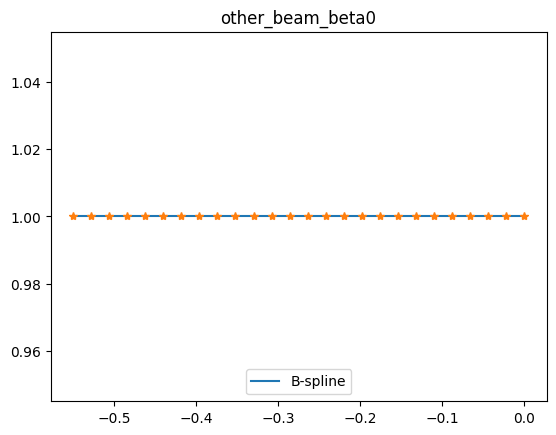

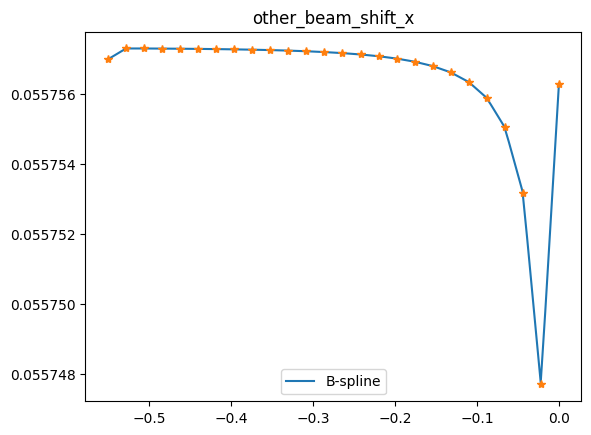

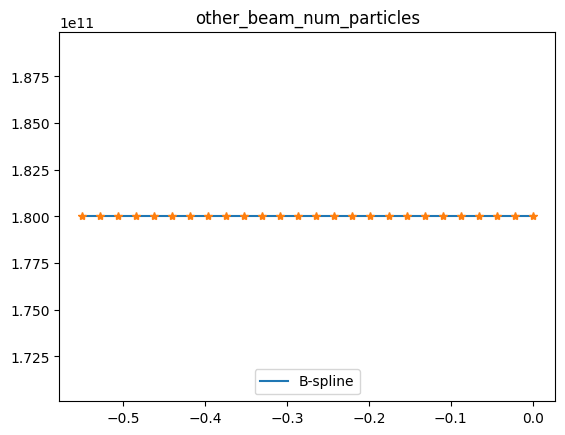

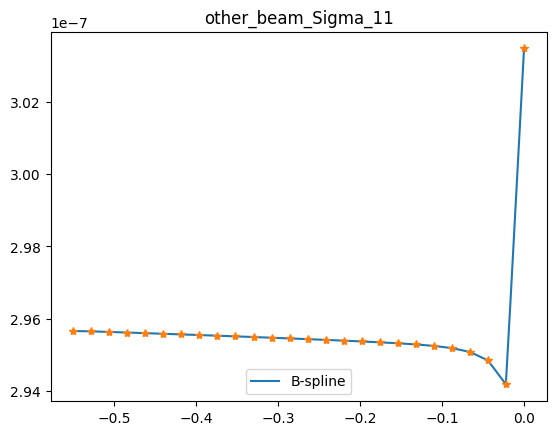

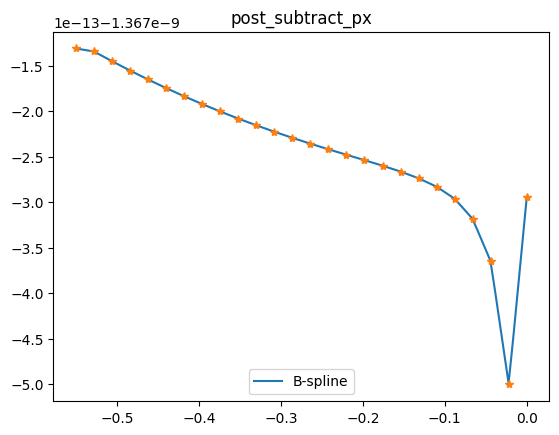

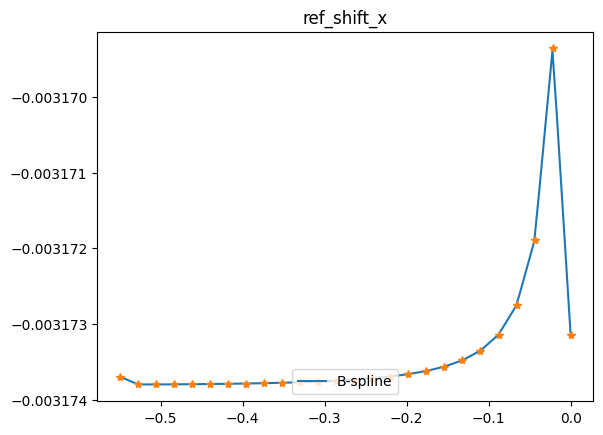

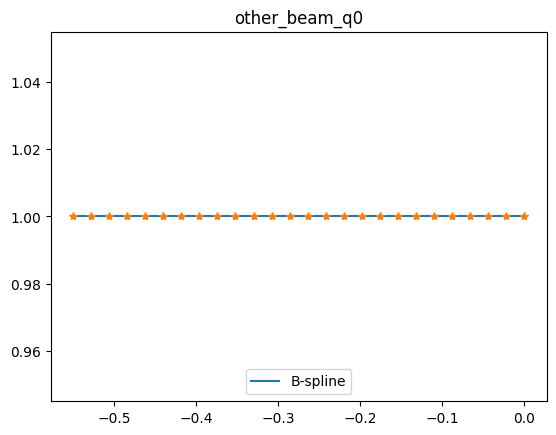

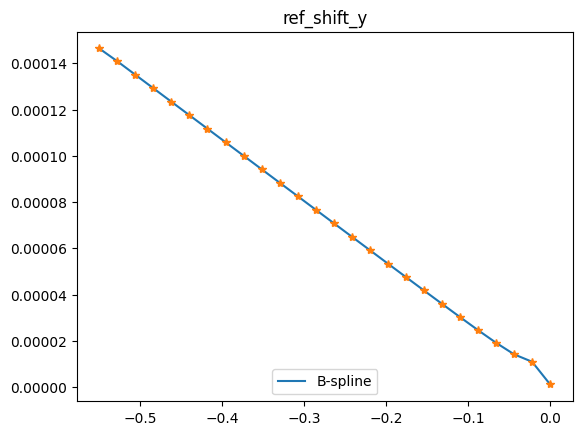

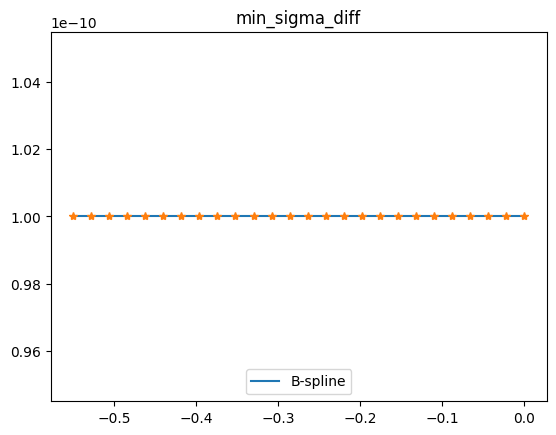

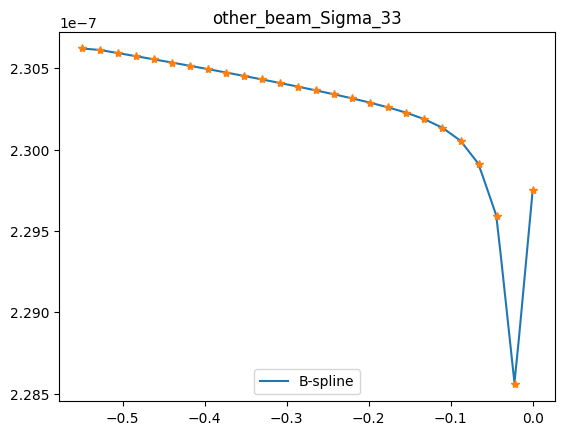

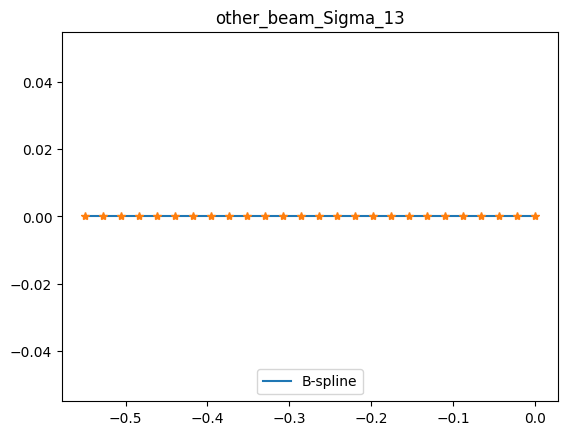

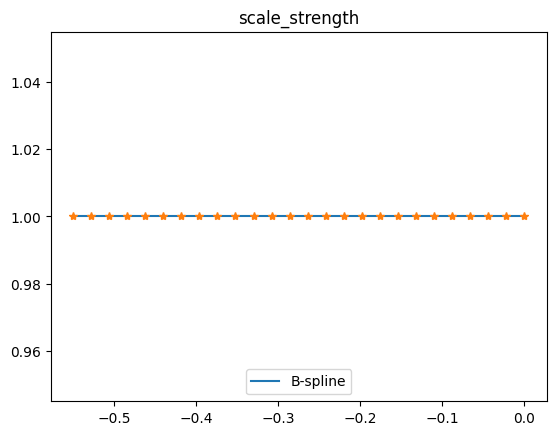

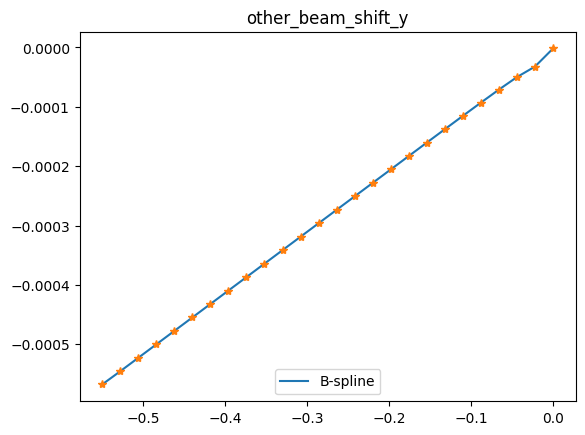

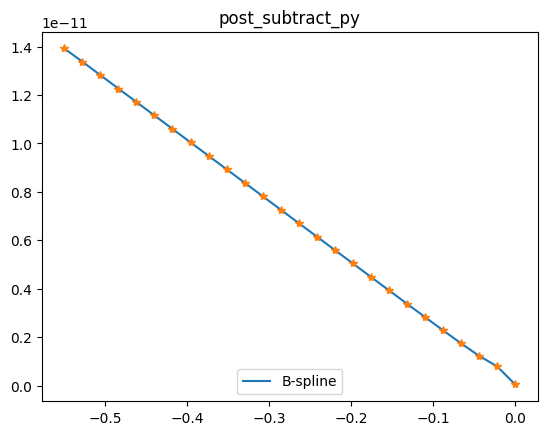

In [6]:
array_xrange = np.linspace(l_xrange[0], l_xrange[-1], 100)
for attr in d_element_attr_vals["lhcb1"]['bb_lr.l5b1_25']:

    fig, ax = plt.subplots()
    y_plot = np.interp(array_xrange, l_xrange, d_element_attr_vals["lhcb1"]['bb_lr.l5b1_25'][attr])
    ax.plot(array_xrange, y_plot, label="B-spline")
    ax.plot(l_xrange, d_element_attr_vals["lhcb1"]['bb_lr.l5b1_25'][attr], '*')
    ax.legend(loc="lower center")
    ax.set_title(attr)
    #ax.set_ylim(-20, 10)
    plt.show()

In [32]:
def interp(x, l_xrange, l_yrange):
    assert isinstance(x, float) or isinstance(x, int)
    for x1, x2, y1, y2 in zip(l_xrange[:-1], l_xrange[1:], l_yrange[:-1], l_yrange[1:]):
        if x1 <= x <= x2:
            return y1 + (y2 - y1) * (x - x1) / (x2 - x1)
            
def make_linear_interp(model):
    return lambda x: interp(x, model['l_xrange'], model['attr'])

d_element_attr_regression = {"lhcb1": {}, "lhcb2": {}}
for beam in d_element_attr_regression:
    d_element_attr_regression[beam] = {}
    for element in d_element_attr_vals[beam]:
        d_element_attr_regression[beam][element] = {}
        for attr in d_element_attr_vals[beam][element]:
            model = {'l_xrange' : l_xrange, 'attr': d_element_attr_vals[beam][element][attr]}
            d_element_attr_regression[beam][element][attr] = make_linear_interp(model)


In [33]:
d_element_attr_regression['lhcb1']["bb_lr.l5b1_25"]["other_beam_shift_y"](-0.3)

-0.0003106570594072379

In [34]:
d_element_attr_regression['lhcb1']["bb_lr.l5b1_25"]["min_sigma_diff"](-0.3)

1e-10

In [35]:
# Create knob for beam-beam in collider
for beam in d_element_attr_regression:
    for element in d_element_attr_regression[beam]:
        if 'l1' or 'r1' in element:
            sep = 'on_sep1'
        elif 'l5' or 'r5' in element:
            sep = 'on_sep5'
        else:
            continue
        for attr in d_element_attr_regression[beam][element]:
            collider[beam].vars[f'interp_{attr}'] = d_element_attr_regression[beam][element][attr]
            if (
                isinstance(getattr(collider[beam][element], attr), list)
                or isinstance(getattr(collider[beam][element], attr), np.ndarray)
            ):
                setattr(collider[beam].element_refs[element],attr[0], collider[beam].vars[f'interp_{attr}'](collider.vars[sep]))  
            else:
                setattr(collider[beam].element_refs[element],attr, collider[beam].vars[f'interp_{attr}'](collider.vars[sep]))  

In [55]:
d_element_attr_regression['lhcb1']["bb_lr.l5b1_25"]["other_beam_shift_y"](-0.3)

array(-0.00031291)

In [23]:
d_element_attr_regression['lhcb1']["bb_lr.l5b1_25"]["min_sigma_diff"](-0.3)

array(1.e-10)

In [24]:
collider.lhcb1["bb_lr.l5b1_25"].min_sigma_diff

1e-10

Now make a dynamic knob for each BB attribute

In [25]:
collider.lhcb1.element_refs["bb_lr.l5b1_25"].min_sigma_diff = collider.vars['on_sep5'] + collider.vars['on_sep1']**2 + collider.vars['on_sep1']**3

In [26]:
collider.lhcb1.element_refs["bb_lr.l5b1_25"].min_sigma_diff._info()

#  eref['lhcb1']['bb_lr.l5b1_25'].min_sigma_diff._get_value()
   eref['lhcb1']['bb_lr.l5b1_25'].min_sigma_diff = 0.686125

#  eref['lhcb1']['bb_lr.l5b1_25'].min_sigma_diff._expr
   eref['lhcb1']['bb_lr.l5b1_25'].min_sigma_diff = ((vars['on_sep5']+(vars['on_sep1']**2))+(vars['on_sep1']**3))

#  eref['lhcb1']['bb_lr.l5b1_25'].min_sigma_diff._expr._get_dependencies()
   vars['on_sep1'] = -0.55
   vars['on_sep5'] = 0.55

#  eref['lhcb1']['bb_lr.l5b1_25'].min_sigma_diff does not influence any target



In [16]:
collider.discard_trackers()

In [9]:
collider.build_trackers()

Compiling ContextCpu kernels...


d2303b66fe584ad4951da7d5095c9def.c:5035: warning: "_GNU_SOURCE" redefined
 #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
 
In file included from d2303b66fe584ad4951da7d5095c9def.c:50:
/afs/cern.ch/work/c/cdroin/private/example_DA_study/miniforge/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 #define _GNU_SOURCE 1
 
d2303b66fe584ad4951da7d5095c9def.c: In function ‘compt_do’:
d2303b66fe584ad4951da7d5095c9def.c:18160:12: warning: unused variable ‘e_loss_primary_tot’ [-Wunused-variable]
     double e_loss_primary_tot = 0.0;  // [GeV] total energy lost by the macroparticle
            ^~~~~~~~~~~~~~~~~~
d2303b66fe584ad4951da7d5095c9def.c:18157:62: warning: variable ‘ps_e_prime’ set but not used [-Wunused-but-set-variable]
     double e_e_prime, px_e_prime, py_e_prime, pzeta_e_prime, ps_e_prime, pt_e_prime;  // [GeV, 1, 1, 1, 1, 1] scattered primary
                                                              ^~~~~~~~~~
d2303b

Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


30192192d9e6490f925a765ef83ad4bd.c:5035: warning: "_GNU_SOURCE" redefined
 #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
 
In file included from 30192192d9e6490f925a765ef83ad4bd.c:50:
/afs/cern.ch/work/c/cdroin/private/example_DA_study/miniforge/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 #define _GNU_SOURCE 1
 
30192192d9e6490f925a765ef83ad4bd.c: In function ‘compt_do’:
30192192d9e6490f925a765ef83ad4bd.c:18160:12: warning: unused variable ‘e_loss_primary_tot’ [-Wunused-variable]
     double e_loss_primary_tot = 0.0;  // [GeV] total energy lost by the macroparticle
            ^~~~~~~~~~~~~~~~~~
30192192d9e6490f925a765ef83ad4bd.c:18157:62: warning: variable ‘ps_e_prime’ set but not used [-Wunused-but-set-variable]
     double e_e_prime, px_e_prime, py_e_prime, pzeta_e_prime, ps_e_prime, pt_e_prime;  // [GeV, 1, 1, 1, 1, 1] scattered primary
                                                              ^~~~~~~~~~
301921

Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [62]:
collider.lhcb1.element_refs["bb_lr.l5b1_25"].other_beam_shift_y._info()

#  eref['lhcb1']['bb_lr.l5b1_25'].other_beam_shift_y._get_value()
   eref['lhcb1']['bb_lr.l5b1_25'].other_beam_shift_y = -2.502089056154609e-06

#  eref['lhcb1']['bb_lr.l5b1_25'].other_beam_shift_y._expr
   eref['lhcb1']['bb_lr.l5b1_25'].other_beam_shift_y = ((((((0+(-1.205516797641047e-05*(vars['on_sep1']**0)))+(0.0*(vars['on_sep1']**1)))+(0.0009068255592125403*(vars['on_sep1']**2)))+(-0.0005869659289359956*(vars['on_sep1']**3)))+(-0.0010873323268849873*(vars['on_sep1']**4)))+(-0.000659063188295847*(vars['on_sep1']**5)))

#  eref['lhcb1']['bb_lr.l5b1_25'].other_beam_shift_y._expr._get_dependencies()
   vars['on_sep1'] = -0.1

#  eref['lhcb1']['bb_lr.l5b1_25'].other_beam_shift_y does not influence any target



In [19]:
collider.vars['on_sep1']._value

-0.55

In [20]:
collider.lhcb1.element_refs["bb_lr.l5b1_25"].other_beam_shift_y._info()

#  eref['lhcb1']['bb_lr.l5b1_25'].other_beam_shift_y._get_value()
   eref['lhcb1']['bb_lr.l5b1_25'].other_beam_shift_y = -0.0005677373178011407

#  eref['lhcb1']['bb_lr.l5b1_25'].other_beam_shift_y._expr
   eref['lhcb1']['bb_lr.l5b1_25'].other_beam_shift_y = (((((0+(-1.205516797641047e-05*(vars['on_sep1']**0)))+(0.0009068255592125403*(vars['on_sep1']**1)))+(-0.0005869659289359956*(vars['on_sep1']**2)))+(-0.0010873323268849873*(vars['on_sep1']**3)))+(-0.000659063188295847*(vars['on_sep1']**4)))

#  eref['lhcb1']['bb_lr.l5b1_25'].other_beam_shift_y._expr._get_dependencies()
   vars['on_sep1'] = -0.55

#  eref['lhcb1']['bb_lr.l5b1_25'].other_beam_shift_y does not influence any target



In [64]:
collider.lhcb1.element_refs["bb_lr.l5b1_25"].other_beam_shift_y._info()

#  eref['lhcb1']['bb_lr.l5b1_25'].other_beam_shift_y._get_value()
   eref['lhcb1']['bb_lr.l5b1_25'].other_beam_shift_y = 7.820134413378055e-05

#  eref['lhcb1']['bb_lr.l5b1_25'].other_beam_shift_y._expr
   eref['lhcb1']['bb_lr.l5b1_25'].other_beam_shift_y = ((((((0+(-1.205516797641047e-05*(vars['on_sep1']**0)))+(0.0*(vars['on_sep1']**1)))+(0.0009068255592125403*(vars['on_sep1']**2)))+(-0.0005869659289359956*(vars['on_sep1']**3)))+(-0.0010873323268849873*(vars['on_sep1']**4)))+(-0.000659063188295847*(vars['on_sep1']**5)))

#  eref['lhcb1']['bb_lr.l5b1_25'].other_beam_shift_y._expr._get_dependencies()
   vars['on_sep1'] = -0.3

#  eref['lhcb1']['bb_lr.l5b1_25'].other_beam_shift_y does not influence any target



In [4]:
def configure_beam_beam(collider, config_bb):
    collider.configure_beambeam_interactions(
        num_particles=config_bb["num_particles_per_bunch"],
        nemitt_x=config_bb["nemitt_x"],
        nemitt_y=config_bb["nemitt_y"],
    )

    # Configure filling scheme mask and bunch numbers
    if "mask_with_filling_pattern" in config_bb:
        # Initialize filling pattern with empty values
        filling_pattern_cw = None
        filling_pattern_acw = None

        # Initialize bunch numbers with empty values
        i_bunch_cw = None
        i_bunch_acw = None

        if "pattern_fname" in config_bb["mask_with_filling_pattern"]:
            # Fill values if possible
            if config_bb["mask_with_filling_pattern"]["pattern_fname"] is not None:
                fname = "/afs/cern.ch/work/c/cdroin/private/example_DA_study/master_study/master_jobs/filling_scheme/25ns_2464b_2452_1842_1821_236bpi_12inj_hybrid_converted.json"  # config_bb["mask_with_filling_pattern"]["pattern_fname"]
                with open(fname, "r") as fid:
                    filling = json.load(fid)
                filling_pattern_cw = filling["beam1"]
                filling_pattern_acw = filling["beam2"]

                # Only track bunch number if a filling pattern has been provided
                if "i_bunch_b1" in config_bb["mask_with_filling_pattern"]:
                    i_bunch_cw = 411
                if "i_bunch_b2" in config_bb["mask_with_filling_pattern"]:
                    i_bunch_acw = 410

                # Note that a bunch number must be provided if a filling pattern is provided
                # Apply filling pattern
                collider.apply_filling_pattern(
                    filling_pattern_cw=filling_pattern_cw,
                    filling_pattern_acw=filling_pattern_acw,
                    i_bunch_cw=i_bunch_cw,
                    i_bunch_acw=i_bunch_acw,
                )

    return collider


# Read configuration for simulations
with open(
    "/afs/cern.ch/work/c/cdroin/private/example_DA_study/master_study/scans/dynamic_collapse_new/base_collider/xtrack_0000/gen_3/gen_4/gen_5/config.yaml",
    "r",
) as fid:
    config = ryaml.load(fid)

config_bb = config["config_collider"]["config_beambeam"]
collider = configure_beam_beam(collider, config_bb)

Compiling ContextCpu kernels...


ff8ba02f90ab49cdb5efedc264487072.c:5035: warning: "_GNU_SOURCE" redefined
 #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
 
In file included from ff8ba02f90ab49cdb5efedc264487072.c:50:
/afs/cern.ch/work/c/cdroin/private/example_DA_study/miniforge/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 #define _GNU_SOURCE 1
 
ff8ba02f90ab49cdb5efedc264487072.c: In function ‘compt_do’:
ff8ba02f90ab49cdb5efedc264487072.c:18160:12: warning: unused variable ‘e_loss_primary_tot’ [-Wunused-variable]
     double e_loss_primary_tot = 0.0;  // [GeV] total energy lost by the macroparticle
            ^~~~~~~~~~~~~~~~~~
ff8ba02f90ab49cdb5efedc264487072.c:18157:62: warning: variable ‘ps_e_prime’ set but not used [-Wunused-but-set-variable]
     double e_e_prime, px_e_prime, py_e_prime, pzeta_e_prime, ps_e_prime, pt_e_prime;  // [GeV, 1, 1, 1, 1, 1] scattered primary
                                                              ^~~~~~~~~~
ff8ba0

Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


65f73f4244534aa180f5c66d55471ae2.c:5040: warning: "_GNU_SOURCE" redefined
 #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
 
In file included from 65f73f4244534aa180f5c66d55471ae2.c:50:
/afs/cern.ch/work/c/cdroin/private/example_DA_study/miniforge/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 #define _GNU_SOURCE 1
 
65f73f4244534aa180f5c66d55471ae2.c: In function ‘compt_do’:
65f73f4244534aa180f5c66d55471ae2.c:18165:12: warning: unused variable ‘e_loss_primary_tot’ [-Wunused-variable]
     double e_loss_primary_tot = 0.0;  // [GeV] total energy lost by the macroparticle
            ^~~~~~~~~~~~~~~~~~
65f73f4244534aa180f5c66d55471ae2.c:18162:62: warning: variable ‘ps_e_prime’ set but not used [-Wunused-but-set-variable]
     double e_e_prime, px_e_prime, py_e_prime, pzeta_e_prime, ps_e_prime, pt_e_prime;  // [GeV, 1, 1, 1, 1, 1] scattered primary
                                                              ^~~~~~~~~~
65f73f

Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


b2afea3b1c6e4892bce0e5408b3d1ed0.c:5035: warning: "_GNU_SOURCE" redefined
 #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
 
In file included from b2afea3b1c6e4892bce0e5408b3d1ed0.c:50:
/afs/cern.ch/work/c/cdroin/private/example_DA_study/miniforge/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 #define _GNU_SOURCE 1
 
b2afea3b1c6e4892bce0e5408b3d1ed0.c: In function ‘compt_do’:
b2afea3b1c6e4892bce0e5408b3d1ed0.c:18160:12: warning: unused variable ‘e_loss_primary_tot’ [-Wunused-variable]
     double e_loss_primary_tot = 0.0;  // [GeV] total energy lost by the macroparticle
            ^~~~~~~~~~~~~~~~~~
b2afea3b1c6e4892bce0e5408b3d1ed0.c:18157:62: warning: variable ‘ps_e_prime’ set but not used [-Wunused-but-set-variable]
     double e_e_prime, px_e_prime, py_e_prime, pzeta_e_prime, ps_e_prime, pt_e_prime;  // [GeV, 1, 1, 1, 1, 1] scattered primary
                                                              ^~~~~~~~~~
b2afea

Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


55115839b3fe4219bc2837d46fba3c39.c:5040: warning: "_GNU_SOURCE" redefined
 #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
 
In file included from 55115839b3fe4219bc2837d46fba3c39.c:50:
/afs/cern.ch/work/c/cdroin/private/example_DA_study/miniforge/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 #define _GNU_SOURCE 1
 
55115839b3fe4219bc2837d46fba3c39.c: In function ‘compt_do’:
55115839b3fe4219bc2837d46fba3c39.c:18165:12: warning: unused variable ‘e_loss_primary_tot’ [-Wunused-variable]
     double e_loss_primary_tot = 0.0;  // [GeV] total energy lost by the macroparticle
            ^~~~~~~~~~~~~~~~~~
55115839b3fe4219bc2837d46fba3c39.c:18162:62: warning: variable ‘ps_e_prime’ set but not used [-Wunused-but-set-variable]
     double e_e_prime, px_e_prime, py_e_prime, pzeta_e_prime, ps_e_prime, pt_e_prime;  // [GeV, 1, 1, 1, 1, 1] scattered primary
                                                              ^~~~~~~~~~
551158

Done compiling ContextCpu kernels.
bb_lr.l1b1_17 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l1b1_18 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l1b1_19 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l1b1_20 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l1b1_21 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l1b1_22 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l1b1_23 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l1b1_24 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l1b1_25 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l5b1_17 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l5b1_18 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l5b1_19 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l5b1_20 Ref

73ddbc1bd2bf45e1a5c0729f97cf2fb2.c:3702: warning: "_GNU_SOURCE" redefined
 #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
 
In file included from 73ddbc1bd2bf45e1a5c0729f97cf2fb2.c:50:
/afs/cern.ch/work/c/cdroin/private/example_DA_study/miniforge/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 #define _GNU_SOURCE 1
 


Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


d6495649369d4566b1255129a4a6949f.c:7252: warning: "_GNU_SOURCE" redefined
 #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
 
In file included from d6495649369d4566b1255129a4a6949f.c:50:
/afs/cern.ch/work/c/cdroin/private/example_DA_study/miniforge/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 #define _GNU_SOURCE 1
 
d6495649369d4566b1255129a4a6949f.c: In function ‘compt_do’:
d6495649369d4566b1255129a4a6949f.c:10637:12: warning: unused variable ‘e_loss_primary_tot’ [-Wunused-variable]
     double e_loss_primary_tot = 0.0;  // [GeV] total energy lost by the macroparticle
            ^~~~~~~~~~~~~~~~~~
d6495649369d4566b1255129a4a6949f.c:10634:62: warning: variable ‘ps_e_prime’ set but not used [-Wunused-but-set-variable]
     double e_e_prime, px_e_prime, py_e_prime, pzeta_e_prime, ps_e_prime, pt_e_prime;  // [GeV, 1, 1, 1, 1, 1] scattered primary
                                                              ^~~~~~~~~~
d64956

Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [16]:
collider.vars['on_sep1'] = -0.3
collider.vars['on_sep5'] = -0.3

In [14]:
collider.vars['on_sep1']._info()

#  vars['on_sep1']._get_value()
   vars['on_sep1'] = 0.0

#  vars['on_sep1']._expr is None

#  vars['on_sep1']._find_dependant_targets()
   eref['lhcb2']['bb_ho.l5b2_05'].post_subtract_pzeta
   eref['lhcb2']['bb_ho.l5b2_05'].min_sigma_diff
   eref['lhcb2']['bb_ho.l5b2_05']._tan_phi
   eref['lhcb2']['bb_ho.l5b2_05'].threshold_singular
   eref['lhcb2']['bb_ho.l5b2_05']._cos_alpha
   eref['lhcb2']['bb_ho.l5b2_05'].ref_shift_py
   eref['lhcb2']['bb_ho.l5b2_05'].other_beam_shift_zeta
   eref['lhcb2']['bb_ho.l5b2_05'].ref_shift_y
   eref['lhcb2']['bb_ho.l5b2_05']._cos_phi
   eref['lhcb2']['bb_ho.l5b2_05'].ref_shift_pzeta
   ... set _info(limit=None) to get all lines



Compiling ContextCpu kernels...


85d2afd16b49457fbd243cf96d50a971.c:5040: warning: "_GNU_SOURCE" redefined
 #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
 
In file included from 85d2afd16b49457fbd243cf96d50a971.c:50:
/afs/cern.ch/work/c/cdroin/private/example_DA_study/miniforge/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 #define _GNU_SOURCE 1
 
85d2afd16b49457fbd243cf96d50a971.c: In function ‘compt_do’:
85d2afd16b49457fbd243cf96d50a971.c:18165:12: warning: unused variable ‘e_loss_primary_tot’ [-Wunused-variable]
     double e_loss_primary_tot = 0.0;  // [GeV] total energy lost by the macroparticle
            ^~~~~~~~~~~~~~~~~~
85d2afd16b49457fbd243cf96d50a971.c:18162:62: warning: variable ‘ps_e_prime’ set but not used [-Wunused-but-set-variable]
     double e_e_prime, px_e_prime, py_e_prime, pzeta_e_prime, ps_e_prime, pt_e_prime;  // [GeV, 1, 1, 1, 1, 1] scattered primary
                                                              ^~~~~~~~~~
85d2af

Done compiling ContextCpu kernels.
Tracking particles for footprint...
Done tracking.
Done computing footprint.
Tracking particles for footprint...
Done tracking.
Done computing footprint.


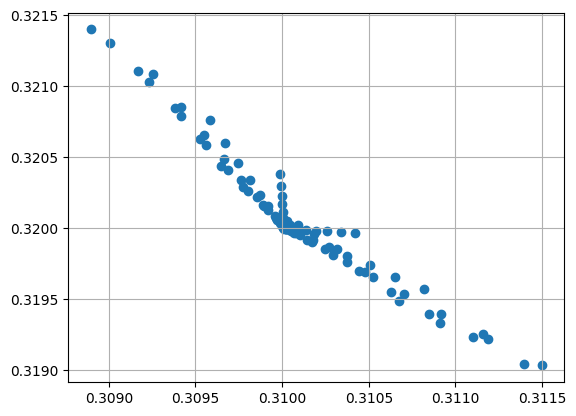

In [19]:
# Function to compute footprint
def return_footprint(collider, emittance, beam="lhcb1", n_turns=2000):
    fp_polar_xm = collider[beam].get_footprint(
        nemitt_x=emittance,
        nemitt_y=emittance,
        n_turns=n_turns,
        linear_rescale_on_knobs=[xt.LinearRescale(knob_name="beambeam_scale", v0=0.0, dv=0.05)],
        freeze_longitudinal=True,
    )

    qx = fp_polar_xm.qx
    qy = fp_polar_xm.qy

    return qx, qy

qx, qy = return_footprint(collider, 2e-6, beam="lhcb1", n_turns=500)
plt.scatter(qx, qy)
plt.grid()
plt.show()


In [20]:
collider = xt.Multiline.from_json(
    "/afs/cern.ch/work/c/cdroin/private/example_DA_study/master_study/scans/dynamic_collapse_new/base_collider/xtrack_0000/gen_3/gen_4/collider.json"
)
collider.build_trackers()

Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Compiling ContextCpu kernels...


eb53c3c19f324f0bb5cfb692cafe9ca4.c:5035: warning: "_GNU_SOURCE" redefined
 #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
 
In file included from eb53c3c19f324f0bb5cfb692cafe9ca4.c:50:
/afs/cern.ch/work/c/cdroin/private/example_DA_study/miniforge/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 #define _GNU_SOURCE 1
 
eb53c3c19f324f0bb5cfb692cafe9ca4.c: In function ‘compt_do’:
eb53c3c19f324f0bb5cfb692cafe9ca4.c:18160:12: warning: unused variable ‘e_loss_primary_tot’ [-Wunused-variable]
     double e_loss_primary_tot = 0.0;  // [GeV] total energy lost by the macroparticle
            ^~~~~~~~~~~~~~~~~~
eb53c3c19f324f0bb5cfb692cafe9ca4.c:18157:62: warning: variable ‘ps_e_prime’ set but not used [-Wunused-but-set-variable]
     double e_e_prime, px_e_prime, py_e_prime, pzeta_e_prime, ps_e_prime, pt_e_prime;  // [GeV, 1, 1, 1, 1, 1] scattered primary
                                                              ^~~~~~~~~~
eb53c3

Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


e355c764730243d495107ab870ae6a82.c:5035: warning: "_GNU_SOURCE" redefined
 #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
 
In file included from e355c764730243d495107ab870ae6a82.c:50:
/afs/cern.ch/work/c/cdroin/private/example_DA_study/miniforge/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 #define _GNU_SOURCE 1
 
e355c764730243d495107ab870ae6a82.c: In function ‘compt_do’:
e355c764730243d495107ab870ae6a82.c:18160:12: warning: unused variable ‘e_loss_primary_tot’ [-Wunused-variable]
     double e_loss_primary_tot = 0.0;  // [GeV] total energy lost by the macroparticle
            ^~~~~~~~~~~~~~~~~~
e355c764730243d495107ab870ae6a82.c:18157:62: warning: variable ‘ps_e_prime’ set but not used [-Wunused-but-set-variable]
     double e_e_prime, px_e_prime, py_e_prime, pzeta_e_prime, ps_e_prime, pt_e_prime;  // [GeV, 1, 1, 1, 1, 1] scattered primary
                                                              ^~~~~~~~~~
e355c7

Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [21]:
collider.vars['on_sep1']._info()

#  vars['on_sep1']._get_value()
   vars['on_sep1'] = -0.55

#  vars['on_sep1']._expr is None

#  vars['on_sep1']._find_dependant_targets()
   eref['lhcb2']['bb_ho.l5b2_05']._sin_phi
   eref['lhcb2']['bb_ho.l5b2_05'].post_subtract_x
   eref['lhcb2']['bb_ho.l5b2_05'].post_subtract_px
   eref['lhcb2']['bb_ho.l5b2_05'].flag_beamstrahlung
   eref['lhcb2']['bb_ho.l5b2_05'].ref_shift_x
   eref['lhcb2']['bb_ho.l5b2_05']._cos_alpha
   eref['lhcb2']['bb_ho.l5b2_05'].other_beam_shift_py
   eref['lhcb2']['bb_ho.l5b2_05'].num_slices_other_beam
   eref['lhcb2']['bb_ho.l5b2_05'].other_beam_q0
   eref['lhcb2']['bb_ho.l5b2_05'].post_subtract_pzeta
   ... set _info(limit=None) to get all lines



Compiling ContextCpu kernels...


68d39de0b38f4df3bd7fb761201ce57d.c:5040: warning: "_GNU_SOURCE" redefined
 #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
 
In file included from 68d39de0b38f4df3bd7fb761201ce57d.c:50:
/afs/cern.ch/work/c/cdroin/private/example_DA_study/miniforge/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 #define _GNU_SOURCE 1
 
68d39de0b38f4df3bd7fb761201ce57d.c: In function ‘compt_do’:
68d39de0b38f4df3bd7fb761201ce57d.c:18165:12: warning: unused variable ‘e_loss_primary_tot’ [-Wunused-variable]
     double e_loss_primary_tot = 0.0;  // [GeV] total energy lost by the macroparticle
            ^~~~~~~~~~~~~~~~~~
68d39de0b38f4df3bd7fb761201ce57d.c:18162:62: warning: variable ‘ps_e_prime’ set but not used [-Wunused-but-set-variable]
     double e_e_prime, px_e_prime, py_e_prime, pzeta_e_prime, ps_e_prime, pt_e_prime;  // [GeV, 1, 1, 1, 1, 1] scattered primary
                                                              ^~~~~~~~~~
68d39d

Done compiling ContextCpu kernels.
Tracking particles for footprint...
Done tracking.
Done computing footprint.
Tracking particles for footprint...
Done tracking.
Done computing footprint.


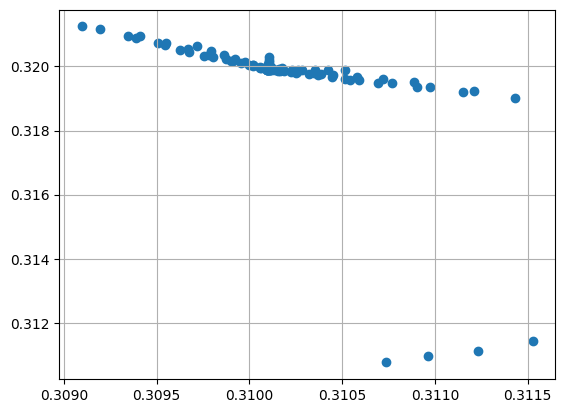

In [22]:
qx, qy = return_footprint(collider, 2e-6, beam="lhcb1", n_turns=500)
plt.scatter(qx, qy)
plt.grid()
plt.show()

In [23]:
collider.lhcb1.element_refs['bb_ho.l5b1_05']._sin_phi._info()

#  eref['lhcb1']['bb_ho.l5b1_05']._sin_phi._get_value()
   eref['lhcb1']['bb_ho.l5b1_05']._sin_phi = 0.00013500395005161818

#  eref['lhcb1']['bb_ho.l5b1_05']._sin_phi._expr
   eref['lhcb1']['bb_ho.l5b1_05']._sin_phi = (((((0+(0.00013483577313459365*(vars['on_sep1']**0)))+(-2.4897302737393527e-06*(vars['on_sep1']**1)))+(-1.235950911671124e-05*(vars['on_sep1']**2)))+(-2.6089733464046155e-05*(vars['on_sep1']**3)))+(-1.9704693731932007e-05*(vars['on_sep1']**4)))

#  eref['lhcb1']['bb_ho.l5b1_05']._sin_phi._expr._get_dependencies()
   vars['on_sep1'] = -0.55

#  eref['lhcb1']['bb_ho.l5b1_05']._sin_phi does not influence any target



In [27]:
collider.vars['on_sep1'] = -0.0


In [28]:
collider.lhcb1.element_refs['bb_ho.l5b1_05']._sin_phi._info()

#  eref['lhcb1']['bb_ho.l5b1_05']._sin_phi._get_value()
   eref['lhcb1']['bb_ho.l5b1_05']._sin_phi = 0.00013483577313459365

#  eref['lhcb1']['bb_ho.l5b1_05']._sin_phi._expr
   eref['lhcb1']['bb_ho.l5b1_05']._sin_phi = (((((0+(0.00013483577313459365*(vars['on_sep1']**0)))+(-2.4897302737393527e-06*(vars['on_sep1']**1)))+(-1.235950911671124e-05*(vars['on_sep1']**2)))+(-2.6089733464046155e-05*(vars['on_sep1']**3)))+(-1.9704693731932007e-05*(vars['on_sep1']**4)))

#  eref['lhcb1']['bb_ho.l5b1_05']._sin_phi._expr._get_dependencies()
   vars['on_sep1'] = -0.0

#  eref['lhcb1']['bb_ho.l5b1_05']._sin_phi does not influence any target



Tracking particles for footprint...
Done tracking.
Done computing footprint.
Tracking particles for footprint...
Done tracking.
Done computing footprint.


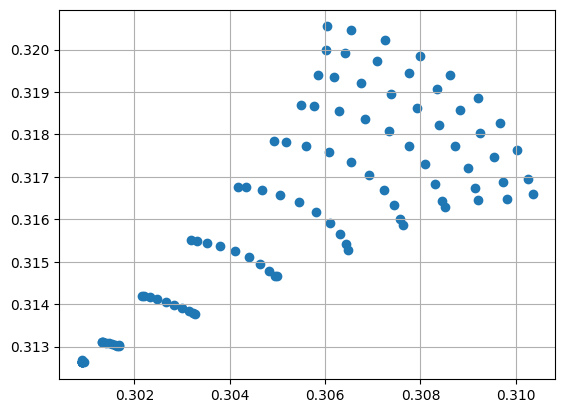

In [29]:
qx, qy = return_footprint(collider, 2e-6, beam="lhcb1", n_turns=500)
plt.scatter(qx, qy)
plt.grid()
plt.show()